In [11]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#nltk.download('wordnet')


df = pd.read_excel("google reviews cleaned df_text.xlsx")
print(df.columns)

Index(['rating', 'reservation_recommended', 'visited_on', 'wait_time',
       'published_date', 'is_local_guide', 'original_language', 'review_text'],
      dtype='object')


We begin pre-processing the google reviews with text for sentimental analysis.

In [12]:
#nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """Lowercase, remove special characters, and extra spaces."""
    text = text.lower().strip()
    text = re.sub(r'[^a-z0-9\s]', '', text) # Keep only alphanumeric characters
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words] # Remove stopwords + Lemmatization
    return ' '.join(words)

df['review_text'] = df['review_text'].apply(clean_text)
df['is_english_speaker'] = df['original_language'].apply(lambda x: 1 if x == 'en' else 0)

df = df.drop(columns = ['reservation_recommended', 'wait_time', 'is_local_guide', 'original_language'])

Let's preview the dataset.

In [13]:
print(df.head())

   rating visited_on published_date  \
0       5    Weekday     2025-02-27   
1       5    Weekday     2025-02-27   
2       5    Weekday     2025-02-27   
3       5    Weekday     2025-02-27   
4       5    Weekday     2025-02-27   

                                         review_text  is_english_speaker  
0  great day universal studio singapore visited j...                   1  
1  universal studio singapore popular tourist des...                   0  
2                           amazing modern beautiful                   0  
3  one go theme park singapore also osaka japan u...                   1  
4  bit old still fun recommended play 16001900 pe...                   0  


Let's segment the reviews into 5 segments based on 'Stars'.

C:\Users\HopeE\AppData\Local\Temp\ipykernel_13740\391236939.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='viridis')


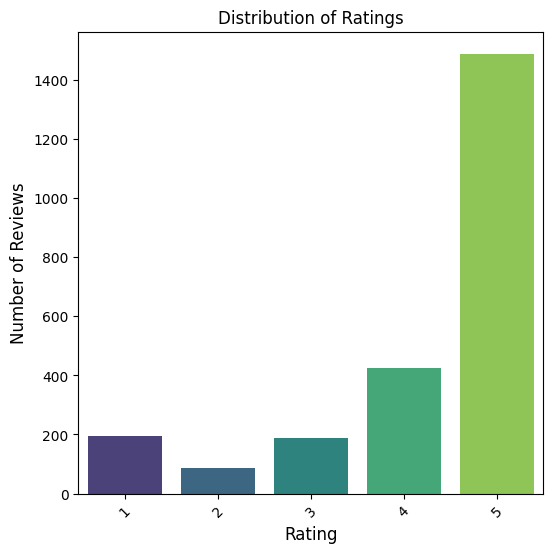

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each rating
rating_counts = df['rating'].value_counts().sort_index()

# Create the bar plot
plt.figure(figsize=(6, 6))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='viridis')

# Adding labels and title
plt.title('Distribution of Ratings', fontsize=12)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=45)

# Show the plot
plt.show()

Let's conduct sentimental analysis to better understand the tone behind the text data.

In [15]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

def get_sentiment(text):
    sentiment = sid.polarity_scores(text)
    return sentiment['compound']  # The compound score indicates overall sentiment

df['sentiment'] = df['review_text'].apply(get_sentiment)
df['sentiment_label'] = df['sentiment'].apply(lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral'))
df['sentiment_label'].value_counts()

sentiment_label
positive    1887
neutral      275
negative     218
Name: count, dtype: int64

We follow up by plotting the sentiment label against the stars of the review.

C:\Users\HopeE\AppData\Local\Temp\ipykernel_13740\3653652341.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment_label', y='rating', data=df, palette='viridis')


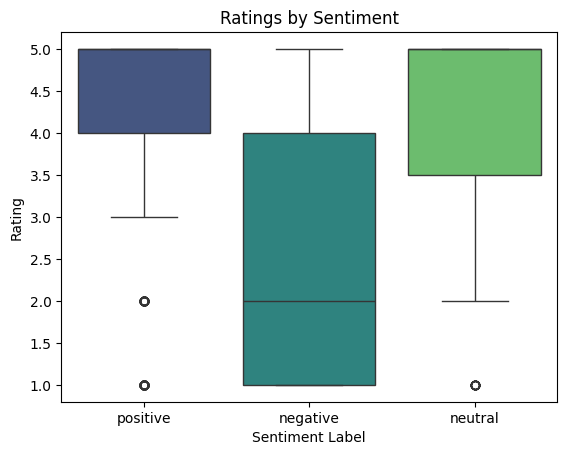

In [16]:
sns.boxplot(x='sentiment_label', y='rating', data=df, palette='viridis')
plt.title('Ratings by Sentiment')
plt.xlabel('Sentiment Label')
plt.ylabel('Rating')
plt.show()

We now look for the probable occurances of high-risk interactions stated in the reviews. We define "high-risk interaction" as revirews with ratings 1-2 stars and reviews with highly negative sentiment scores. We proceed to create a list of high-risk keywords and identify the frequency of occurance of these keywords in the filtered out "high-risk" reviews.

In [22]:
# Define high-risk keywords
high_risk_keywords = [
    "accident", "injury", "unsafe", "dangerous", "broken", "malfunction",
    "sick", "poisoning", "crowded", "long wait", "unhygienic", "fell", "hurt",
    "defective", "improper", "hazard", "inadequate", "negligence", "danger",
    'bad', 'terrible', 'awful', 'poor', 'worse', 'horrible', 
    'rude', 'unprofessional', 'slow', 'expensive', 'overpriced',
    'manager', 'complaint', 'refund'
]

def engineer_features(df, keywords):
    featured_df = df.copy()

    # Create interaction feature between rating and sentiment
    featured_df['rating_sentiment_diff'] = featured_df['rating']/5 - (featured_df['sentiment'] + 1)/2
    
    # Create feature for review length (might indicate detail of complaint)
    featured_df['review_length'] = featured_df['review_text'].apply(lambda x: len(str(x).split()) if isinstance(x, str) else 0)
    
    for keyword in keywords:
        featured_df[f'has_{keyword}'] = featured_df['review_text'].apply(
            lambda x: 1 if isinstance(x, str) and keyword in x.lower() else 0
        )
    
    # Create a complaint keyword count feature
    featured_df['complaint_keyword_count'] = featured_df[[f'has_{keyword}' for keyword in keywords]].sum(axis=1)
    
    featured_df['high_risk'] = ((featured_df['rating'] <= 2) | 
                                (featured_df['sentiment'] <= -0.5)).astype(int)
    
    # Define features and target
    X = featured_df.drop(['high_risk', 'review_text'], axis=1)  # We'll handle review_text separately with TF-IDF
    y = featured_df['high_risk']

    # Keep clean review text for TF-IDF
    review_text = featured_df['review_text']
    
    return X, review_text, y



We now construct a function to build and evaluate models using cross-validation.

In [23]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import lightgbm as lgb
import numpy as np

def model_evaluation(X, review_text, y, n_cv_folds = 5):
    X_train, X_test, text_train, text_test, y_train, y_test = train_test_split(
        X, review_text, y, test_size=0.2, random_state=42, stratify=y
    )

    # Define preprocessing for numerical features
    numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    numerical_transformer = StandardScaler()
    
    # Define preprocessing for categorical features
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    
    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    # Define the TF-IDF vectorizer for review text
    tfidf = TfidfVectorizer(max_features=1000, min_df=5, max_df=0.7)
    
    # Create TF-IDF features
    tfidf_train = tfidf.fit_transform(text_train)
    tfidf_test = tfidf.transform(text_test)
    
    # Preprocess X_train and X_test
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    # Combine TF-IDF features with other features
    X_train_combined = np.hstack((X_train_processed, tfidf_train.toarray()))
    X_test_combined = np.hstack((X_test_processed, tfidf_test.toarray()))
    
    # Define and train LightGBM model
    model = lgb.LGBMClassifier(random_state=42)
    
    # Define parameter grid for hyperparameter tuning
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [31, 50, 100],
        'max_depth': [-1, 5, 10],
        'class_weight': [None, 'balanced']
    }
    
    # Perform grid search
    grid_search = GridSearchCV(
        model, param_grid, cv=n_cv_folds, scoring='f1', n_jobs=-1, verbose=1
    )
    
    # Train the model
    print("Training model with cross-validation...")
    grid_search.fit(X_train_combined, y_train)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
    
    # Make predictions
    y_pred = best_model.predict(X_test_combined)
    y_pred_proba = best_model.predict_proba(X_test_combined)[:, 1]
    
    # Evaluate the model
    print("\nModel Evaluation:")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
    
    # Plot feature importance
    feature_importance = best_model.feature_importances_
    feature_names = numerical_features + [f"ohe_{cat}" for cat in categorical_features] + [f"tfidf_{i}" for i in range(tfidf_train.shape[1])]
    
    # Get the indices of the top 20 features
    top_features_idx = np.argsort(feature_importance)[-20:]
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(top_features_idx)), 
             feature_importance[top_features_idx], 
             align='center')
    plt.yticks(range(len(top_features_idx)), 
               [feature_names[i] for i in top_features_idx])
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Feature Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    
    return best_model, preprocessor, tfidf

Prediction Function for New Data

In [24]:
def predict_risk(model, preprocessor, tfidf, new_data):
    """
    Make predictions on new data
    """
    # Clean and preprocess the text
    new_data['clean_review'] = new_data['review_text'].apply(clean_text)
    
    # Extract text features
    text_features = tfidf.transform(new_data['clean_review'])
    
    # Preprocess other features
    X_new = new_data.drop(['review_text', 'clean_review'], axis=1)
    X_new_processed = preprocessor.transform(X_new)
    
    # Combine features
    X_new_combined = np.hstack((X_new_processed, text_features.toarray()))
    
    # Make predictions
    risk_proba = model.predict_proba(X_new_combined)[:, 1]
    
    # Flag high-risk interactions based on probability threshold (0.5)
    high_risk = (risk_proba >= 0.5).astype(int)
    
    # Add predictions to the data
    result = new_data.copy()
    result['risk_probability'] = risk_proba
    result['high_risk_flag'] = high_risk
    
    return result



Let's test our models.

Training model with cross-validation...
Fitting 5 folds for each of 162 candidates, totalling 810 fits
[LightGBM] [Info] Number of positive: 242, number of negative: 1662
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9927
[LightGBM] [Info] Number of data points in the train set: 1904, number of used features: 423
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.127101 -> initscore=-1.926839
[LightGBM] [Info] Start training from score -1.926839
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

c:\Users\HopeE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\HopeE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       415
           1       1.00      1.00      1.00        61

    accuracy                           1.00       476
   macro avg       1.00      1.00      1.00       476
weighted avg       1.00      1.00      1.00       476


Confusion Matrix:
[[415   0]
 [  0  61]]

ROC AUC Score: 1.0000

Model building and evaluation complete!


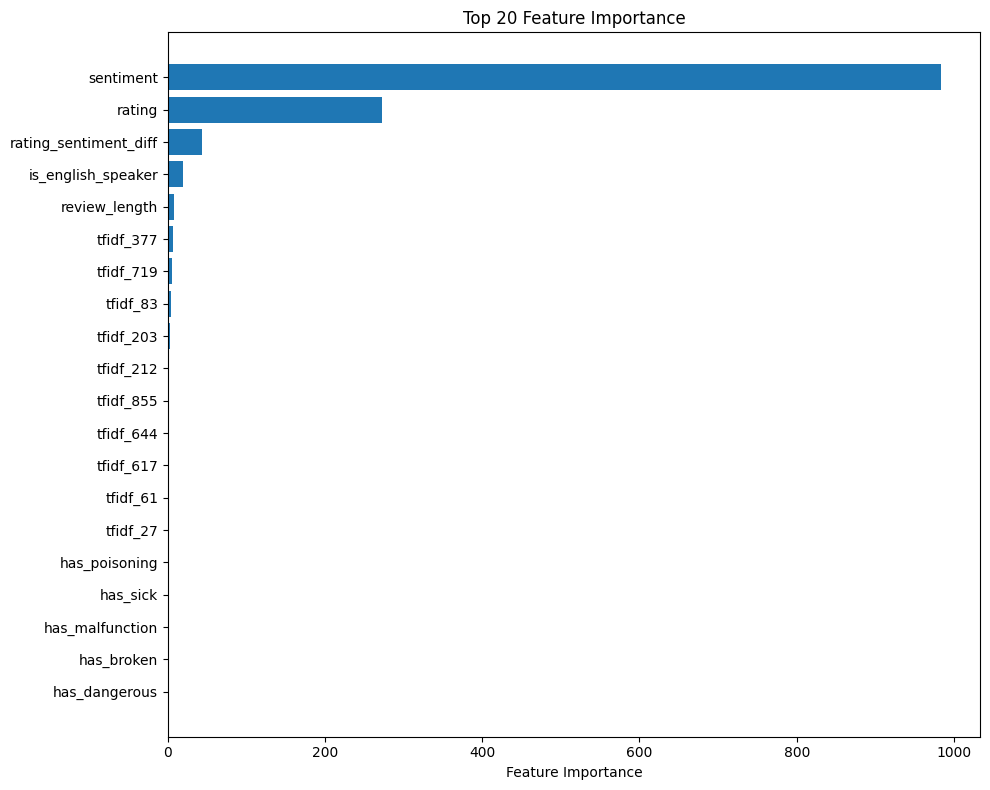

In [39]:
X, review_text, y = engineer_features(df, high_risk_keywords)


#print(y.value_counts())
#print(X.columns)

model, preprocessor, tfidf = model_evaluation(X, review_text, y)

new_data = pd.DataFrame({
        'rating': [1, 4, 2],
        'review_text': [
            "The service was terrible. I waited for an hour and the staff was rude.",
            "Great experience! Everything was perfect and the staff was very helpful.",
            "The food was cold and overpriced. Would not recommend."
        ],
        'visited': ['weekday', 'weekend', 'weekday'],
        'sentiment': [-0.8, 0.9, -0.6]
    })


#results = predict_risk(model, preprocessor, tfidf, new_data)
    
# Display results
#print(results[['review_text', 'rating', 'sentiment', 'risk_probability', 'high_risk_flag']])
    
print("\nModel building and evaluation complete!")